# Dog breed identification using resnext 101

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
from fastai.imports import *
from fastai.model import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.set_device(0)

In [4]:
path = "data/dogbreeds/"

In [5]:
sz = 224
arch = resnext101_64
bs = 64

In [6]:
label_csv = f'{path}/labels.csv'

In [7]:
n = len(list(open(label_csv)))-1

In [8]:
val_idx = get_cv_idxs(n)  # cross validation indexes

## Exploring the dataset

In [9]:
!ls {path}

labels.csv  sample_submission.csv  subm  test  tmp  train


In [10]:
label_df = pd.read_csv(label_csv)

In [11]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [12]:
label_pv_table = label_df.pivot_table(index="breed", aggfunc=len).sort_values('id', ascending = False)

In [13]:
label_pv_table.head(5)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [14]:
label_pv_table.tail(5)

,id
breed,
golden_retriever,67
brabancon_griffon,67
komondor,67
briard,66
eskimo_dog,66


In [15]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(path, "train", f'{path}labels.csv', test_name='test', val_idxs=val_idx, suffix='.jpg', tfms=tfms)

In [16]:
len(data.trn_ds), len(data.val_ds), len(data.test_ds)

(8178, 2044, 10357)

In [17]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

### Looking at the pictures and size distribution

In [18]:
fn = path + data.trn_ds.fnames[3]
fn

'data/dogbreeds/train/002211c81b498ef88e1b40b9abf84e1d.jpg'

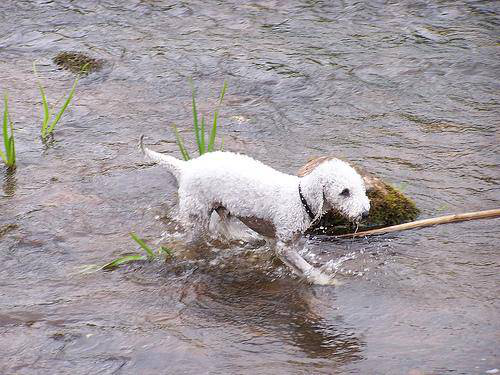

In [19]:
img = PIL.Image.open(fn)
img

In [20]:
img.size

(500, 375)

In [21]:
size_dict = {k: PIL.Image.open(path + k).size for k in data.trn_ds.fnames}

In [22]:
row_size, col_size = list(zip(*size_dict.values()))
row_size = np.array(row_size)  # Conver to np.array to allow slicing
col_size = np.array(col_size)

(array([ 627., 4847., 2455.,  144.,   24.,   16.,    6.,    3.,    2.,    4.]),
 array([ 102. ,  239.5,  377. ,  514.5,  652. ,  789.5,  927. , 1064.5, 1202. , 1339.5, 1477. ]),
 <a list of 10 Patch objects>)

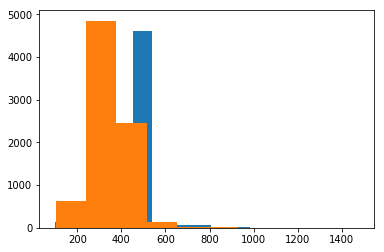

In [23]:
plt.hist(row_size[row_size< 1000])
plt.hist(col_size[row_size < 1000])

Most ImageNet models are trained using sizes 224x224 or 299x299
=> Should work fine on this dataset

## Creating a first model

In [24]:
# Reduces the size of the pictures and stores them in 'tmp' if frames shown to neural net are smaller than 300x300

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(path, "train", f'{path}labels.csv', test_name="test", num_workers=4,
                                    val_idxs=val_idx, suffix=".jpg", tfms = tfms, bs = bs)
    
    return data if sz > 300 else data.resize(340, 'tmp')

In [25]:
data = get_data(sz=sz, bs=bs)  # Start with smaller sizes like 64x64 and if that works, use larger sizes

In [26]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

### Train first model with precompute

In [27]:
learn.lr_find()

 86%|████████▌ | 110/128 [00:01<00:00, 63.42it/s, loss=15.9]


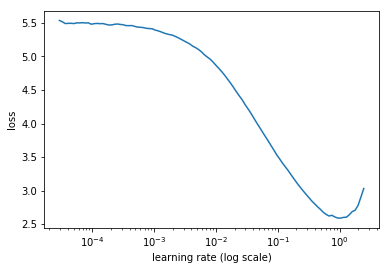

In [28]:
learn.sched.plot()

In [29]:
learn.fit(1e-2, n_cycle=5)

epoch      trn_loss   val_loss   accuracy                   
    0      1.01244    0.392302   0.902153  
    1      0.454894   0.310288   0.913405                    
    2      0.312734   0.268467   0.922211                    
    3      0.247585   0.259423   0.918297                    
    4      0.199505   0.256051   0.919276                    



[array([0.25605]), 0.9192759287334001]

### Using image augmentation
Comparing the trn_loss and val_loss shows that we have been overfitting. Switch on dropout

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)  # ps is dropout prob

In [31]:
learn.precompute = False  # so that image augmentation does something

In [32]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                   
    0      1.793163   0.957184   0.864971  
    1      0.928765   0.473681   0.896282                    
    2      0.649699   0.362627   0.911937                    
    3      0.525043   0.310137   0.919276                    
    4      0.467711   0.287564   0.92319                     



[array([0.28756]), 0.9231898230582534]

In [33]:
learn.fit(1e-2, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.421806   0.273529   0.922701  
    1      0.391232   0.258848   0.922701                    



[array([0.25885]), 0.9227005862676467]

In [34]:
learn.save("224_pre")

In [35]:
learn.load("224_pre")

### Increase the cycle length and the size of the input images
When we are underfitting and the accuracy is not increasing, we might be doing restarts before actually reaching a minimum => Increase `cycle_len` using `cycle_mult`.

Start training on a smaller size (here 224x224) and then increasing the size (here 299x299) is a very effective way to reduce overfitting. This is possible when using fully convolutional architectures. Would not work for example for vgg.

In [36]:
learn.set_data(get_data(299,bs))

In [37]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.385272   0.247514   0.927593  
    1      0.349641   0.238973   0.931018                    
    2      0.307105   0.231088   0.930039                    
    3      0.310264   0.232784   0.932485                    
    4      0.281117   0.227617   0.929061                    
    5      0.265169   0.22087    0.930528                    
    6      0.247454   0.219384   0.934442                    



[array([0.21938]), 0.9344422700587084]

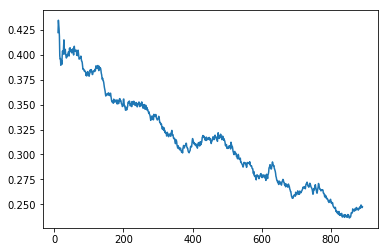

In [38]:
learn.sched.plot_loss()

In [39]:
learn.save("299_pre")

In [212]:
learn.load("299_pre")

Actually the model could be trained a little further at this point, if I wanted to invest more time, it is not overfitting yet...

We could have tried unfreezing earlier layers but the dataset is part of imagenet, on which the network was pretrained on, so that it does not help in this case.

Once we have a working notebook, go back to beginning and run everything again with entire dataset (only 80% used until here).

Try a better architecture or larger images if GPU allows it.

Possible steps:
1. resnet34
1. resnext50
1. resnext 101

**When switching to a larger model with more parameters, you might have to increase dropout!**

## Evaluation

In [41]:
from sklearn import metrics

In [59]:
log_preds, y = learn.TTA()

In [60]:
probs = np.mean(np.exp(log_preds), axis=0)

In [61]:
preds = np.argmax(probs, axis=1)

In [62]:
acc = np.mean(preds == y)

In [63]:
acc

0.9339530332681018

In [64]:
metrics.log_loss(y, probs)

0.21966796860895652

## Create submission for Kaggle

Guidelines from Kaggle

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:


`id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083`

In [50]:
data.classes[:5]

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier']

Filenames in test dataset

In [53]:
data.test_ds.fnames[:5]

['test/d0001158eaa567fc5df05e13f57248f6.jpg',
 'test/1bb0731610f815230a92921263987805.jpg',
 'test/00b965deff7c711cfeaa927ce52f8653.jpg',
 'test/02efe659755a4c9d2da69035c43fa5fb.jpg',
 'test/81ebfca86182cffe4be77fe1496f22ba.jpg']

**Use Test Time Augmentation (TTA) for better results**

In [66]:
log_preds, y = learn.TTA(is_test=True)

In [67]:
probs = np.mean(np.exp(log_preds), axis=0)  # Average over  5 images of TTA

In [68]:
probs.shape

(10357, 120)

In [78]:
df = pd.DataFrame(probs)

In [79]:
df.columns = data.classes

In [80]:
df.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,1.528264e-05,2.483562e-06,8.011622e-06,8.333982e-06,3.856282e-05,3.900028e-05,8.800457e-05,8.418925e-06,4.432651e-05,2.076598e-05,...,4.606410e-06,2.362763e-04,4.814042e-06,1.974571e-05,3.677830e-06,3.580111e-05,9.853824e-01,6.156950e-05,5.190604e-04,1.690952e-05
1,2.673765e-05,1.653623e-04,1.613188e-04,4.415382e-05,3.277727e-05,4.227869e-04,1.781702e-04,5.870145e-03,8.860008e-05,5.174130e-05,...,5.061819e-05,6.660171e-04,1.351916e-04,7.142380e-03,3.974891e-05,3.679531e-05,3.450065e-05,8.267912e-03,3.838119e-04,1.564746e-05
2,1.894888e-03,1.312488e-03,1.416899e-04,5.362082e-05,2.406842e-04,1.780639e-04,9.112345e-04,2.788482e-04,9.511925e-05,4.983543e-05,...,5.229099e-05,4.819465e-04,1.709608e-04,4.910125e-04,6.011755e-05,5.619642e-05,4.114111e-04,1.665749e-03,1.086034e-03,4.272760e-04
3,2.084142e-07,6.296851e-05,9.273076e-06,5.657449e-06,5.001249e-08,2.595784e-07,2.032761e-07,2.108283e-07,5.404594e-07,1.620763e-08,...,3.122059e-08,9.360431e-07,4.989897e-07,1.185846e-06,2.477043e-07,2.388284e-06,4.200988e-07,9.792391e-05,4.473398e-05,6.457491e-07
4,2.573803e-05,3.705676e-08,4.061194e-08,3.692698e-07,5.889320e-08,9.715838e-08,7.334543e-07,4.195821e-07,1.127889e-06,4.651658e-05,...,1.488985e-07,4.650053e-07,1.909388e-07,1.200736e-07,1.380293e-07,4.839736e-07,4.732979e-08,1.408342e-07,9.482820e-08,1.162803e-06


Insert the filenames (remove "rest/" and .jpg):

In [81]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [82]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,d0001158eaa567fc5df05e13f57248f6,1.528264e-05,2.483562e-06,8.011622e-06,8.333982e-06,3.856282e-05,3.900028e-05,8.800457e-05,8.418925e-06,4.432651e-05,...,4.606410e-06,2.362763e-04,4.814042e-06,1.974571e-05,3.677830e-06,3.580111e-05,9.853824e-01,6.156950e-05,5.190604e-04,1.690952e-05
1,1bb0731610f815230a92921263987805,2.673765e-05,1.653623e-04,1.613188e-04,4.415382e-05,3.277727e-05,4.227869e-04,1.781702e-04,5.870145e-03,8.860008e-05,...,5.061819e-05,6.660171e-04,1.351916e-04,7.142380e-03,3.974891e-05,3.679531e-05,3.450065e-05,8.267912e-03,3.838119e-04,1.564746e-05
2,00b965deff7c711cfeaa927ce52f8653,1.894888e-03,1.312488e-03,1.416899e-04,5.362082e-05,2.406842e-04,1.780639e-04,9.112345e-04,2.788482e-04,9.511925e-05,...,5.229099e-05,4.819465e-04,1.709608e-04,4.910125e-04,6.011755e-05,5.619642e-05,4.114111e-04,1.665749e-03,1.086034e-03,4.272760e-04
3,02efe659755a4c9d2da69035c43fa5fb,2.084142e-07,6.296851e-05,9.273076e-06,5.657449e-06,5.001249e-08,2.595784e-07,2.032761e-07,2.108283e-07,5.404594e-07,...,3.122059e-08,9.360431e-07,4.989897e-07,1.185846e-06,2.477043e-07,2.388284e-06,4.200988e-07,9.792391e-05,4.473398e-05,6.457491e-07
4,81ebfca86182cffe4be77fe1496f22ba,2.573803e-05,3.705676e-08,4.061194e-08,3.692698e-07,5.889320e-08,9.715838e-08,7.334543e-07,4.195821e-07,1.127889e-06,...,1.488985e-07,4.650053e-07,1.909388e-07,1.200736e-07,1.380293e-07,4.839736e-07,4.732979e-08,1.408342e-07,9.482820e-08,1.162803e-06


In [83]:
SUBM = f'{path}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)  # index=False means not writing row names

In [84]:
FileLink(f'{SUBM}subm.gz')

/home/fabiograetz/fastai/data/dogbreeds/subm/subm.gz

## Individual prediction

In [270]:
file = data.val_ds.fnames[0]
file

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

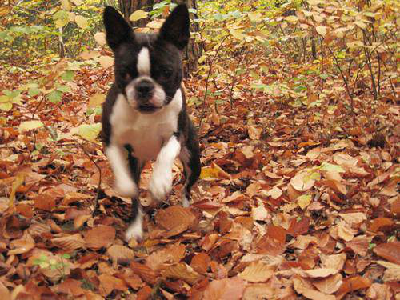

In [262]:
PIL.Image.open(path+file).resize((400,300))

In [263]:
trn_tfms, _ = tfms_from_model(arch, sz)

In [264]:
path+file

'data/dogbreeds/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [265]:
im = trn_tfms(np.array(Image.open(path+file))/255)

In [266]:
preds = learn.predict_array(im[None])  # [None] transforms the image to a tensor (minibatch of size 1)

In [267]:
pred = np.argmax(preds, axis=1)

In [268]:
data.classes[pred[0]]

'boston_bull'

In [271]:
label_df[label_df['id'] == file[6:-4]]  # file[6:-4] deletes the folder name and suffix .jpg

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
